## [作業重點]
了解如何使用 Sklearn 中的 hyper-parameter search 找出最佳的超參數

### 作業
請使用不同的資料集，並使用 hyper-parameter search 的方式，看能不能找出最佳的超參數組合

In [79]:
from sklearn import datasets, metrics
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBClassifier

In [80]:
# 讀取手寫辨識資料集
cancer = datasets.load_breast_cancer()
# 切分訓練集/測試集
x_train, x_test, y_train, y_test = train_test_split(cancer.data, cancer.target, test_size=0.25, random_state=42)

# 建立模型
XGB = XGBClassifier()

0.9609862671660424


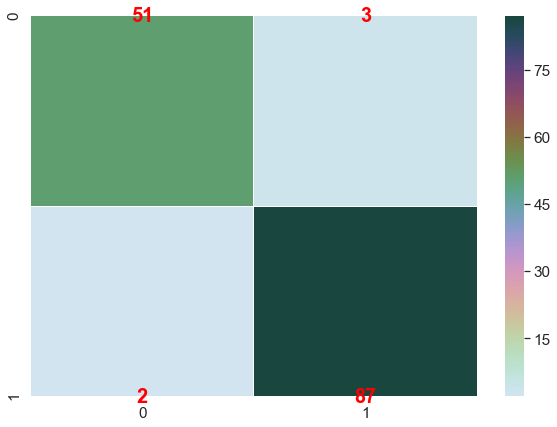

In [81]:
# 先看看使用預設參數得到的結果，約為 0.96的 ROC AUC Score
XGB.fit(x_train, y_train)
y_pred = XGB.predict(x_test)
print(metrics.roc_auc_score(y_test, y_pred))
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

c_metrix = metrics.confusion_matrix(y_test, y_pred)
cmap = sns.cubehelix_palette(start = 1, rot = 3, gamma=0.8, as_cmap = True)
sns.set(font_scale=1.4)#for label size
plt.figure(figsize = (10,7))
sns.heatmap(c_metrix, annot = True,annot_kws={'size':20,'weight':'bold', 'color':'red'},
            cmap = cmap, linewidths = 0.05)



### 還沒調整參數，準確率0.96

In [82]:
# 設定要訓練的超參數組合
max_depth : [2,4,6]  
learning_rate = [0.05,0.1,0.5]
n_estimators = [200,400,600]  
min_child_weight= [1,2,3]
subsample= [0.3,0.6,1]

param_grid = dict(n_estimators = n_estimators, max_depth = max_depth , learning_rate = learning_rate,
                 min_child_weight = min_child_weight, subsample = subsample)

## 建立搜尋物件，放入模型及參數組合字典 (n_jobs=-1 會使用全部 cpu 平行運算)
grid_search = GridSearchCV(XGB, param_grid, scoring = 'roc_auc', n_jobs=-1, verbose=1)

# 開始搜尋最佳參數
grid_result = grid_search.fit(x_train, y_train)

# 預設會跑 3-fold cross-validadtion，總共 9 種參數組合，總共要 train 27 次模型

Fitting 3 folds for each of 243 candidates, totalling 729 fits


/Users/liaoshousan/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   28.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 729 out of 729 | elapsed:  1.7min finished


In [83]:
# 印出最佳結果與最佳參數
print("Best Accuracy: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best Accuracy: 0.990649 using {'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 400, 'subsample': 0.3}


In [84]:
grid_result.best_params_

{'learning_rate': 0.05,
 'max_depth': 5,
 'min_child_weight': 1,
 'n_estimators': 400,
 'subsample': 0.3}

In [85]:
# 使用最佳參數重新建立模型
xgb_bestparam = XGBClassifier(max_depth=grid_result.best_params_['max_depth'],
                    n_estimators= grid_result.best_params_['n_estimators'],
                    learning_rate = grid_result.best_params_['learning_rate'],
                    min_child_weight = grid_result.best_params_['min_child_weight'],
                              subsample = grid_result.best_params_['subsample'])

# 訓練模型
xgb_bestparam.fit(x_train, y_train)

# 預測測試集
y_pred = xgb_bestparam.predict(x_test)

In [86]:
# 調整參數後約可降至 8.30 的 MSE
print(metrics.roc_auc_score(y_test, y_pred))

0.9795047856845609


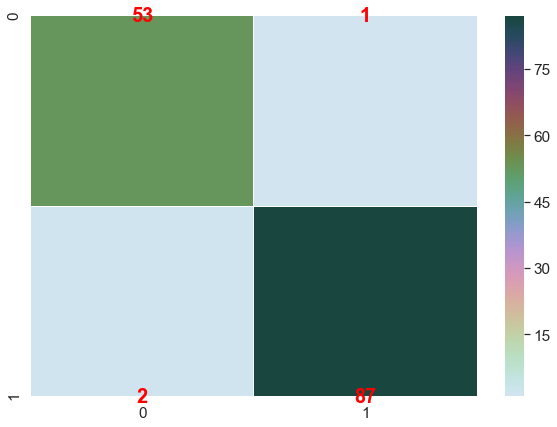

In [87]:
best_c_metrix = metrics.confusion_matrix(y_test, y_pred)
cmap = sns.cubehelix_palette(start = 1, rot = 3, gamma=0.8, as_cmap = True)
# sns.set(font_scale=1.4)#for label size
plt.figure(figsize = (10,7))
sns.heatmap(best_c_metrix, annot_kws={'size':20,'weight':'bold', 'color':'red'},annot = True
            ,cmap = cmap, linewidths = 0.05)





### 調整完參數，提升了將近2%，只剩3筆未命中